In [9]:
# Imports
import csv
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from wordcloud import WordCloud


# Ugly hackery, but necessary: stackoverflow.com/questions/4383571/importing-files-from-different-folder
import sys
sys.path.append('../../')

from src.streaming import spark_functions

# connect to the MongoDB
db = MongoClient()['thesis-dev']

In [10]:
# Load tweets from db, while filtering out non-english tweets
document = " ".join([tweet['text'] for tweet in db.tweets.find()])
counts = dict()
for token in document.split(" "):
    token = ''.join(e for e in token if e.isalnum())
    if token not in counts:
        counts[token] = 0
    else:
        counts[token] += 1

del counts[""]

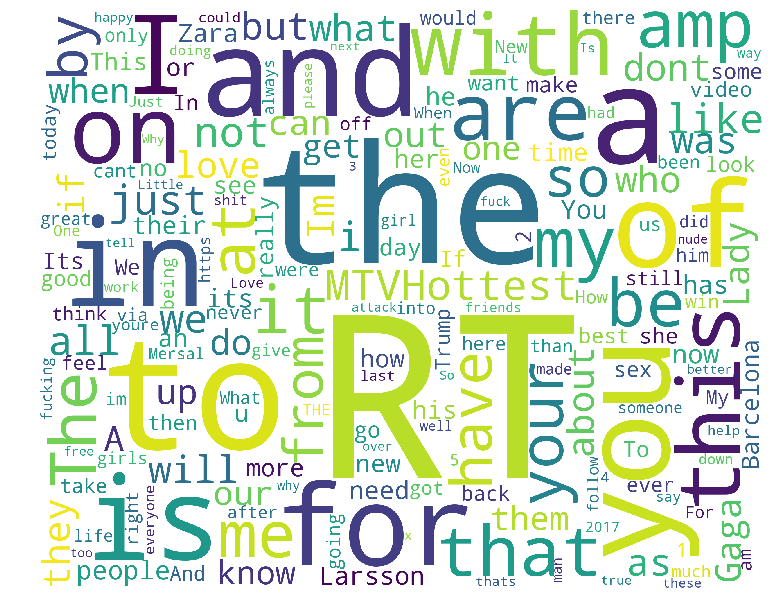

In [11]:
wordcloud = WordCloud(
    stopwords=set(),
    background_color="white",
    width=2500,
    height=2000).generate_from_frequencies(counts)
plt.figure(1, figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("wordcloud_pre.png",bbox_inches='tight')
plt.show()

In [12]:
#Wordcloud after preprocessing
preprocess = spark_functions.preprocessor()
tokenize = spark_functions.tokenizer(remove_stopwords=True)

counts = dict()
for token in tokenize(preprocess(document)):
    token = ''.join(e for e in token if e.isalnum())
    if token not in counts:
        counts[token] = 0
    else:
        counts[token] += 1

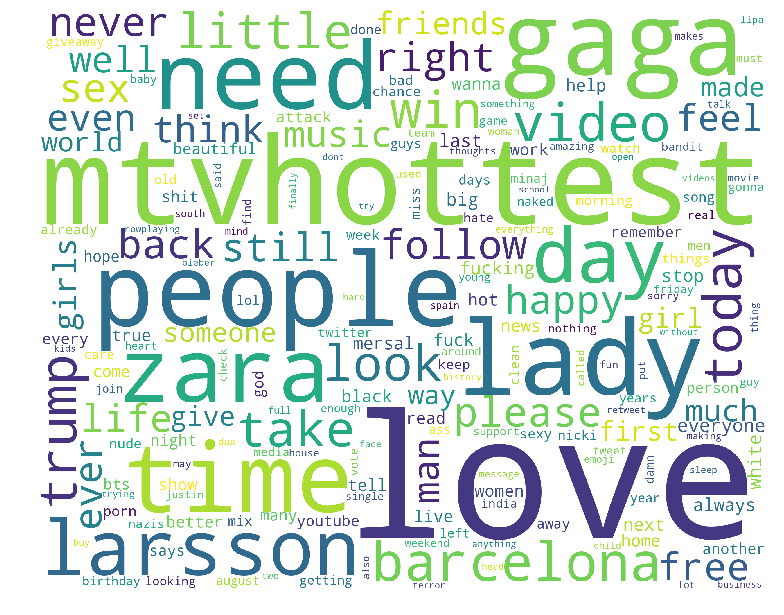

In [13]:
wordcloud = WordCloud(
    stopwords=set(),
    background_color="white",
    width=2500,
    height=2000).generate_from_frequencies(counts)
plt.figure(1, figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("wordcloud_post.png",bbox_inches='tight')
plt.show()

In [15]:
from gensim import corpora, models, similarities

lda_filename = './../../models/lda/gensim/tweets_stream.lda'
dict_filename = './../../data/processed/tweets_stream.dict'

dictionary = corpora.Dictionary.load(dict_filename)
lda = models.LdaModel.load(lda_filename)

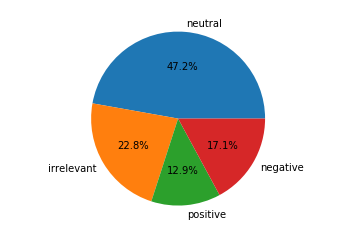

In [17]:
import pickle

# Load sentiment model
classifier_f = open("./../../models/naive_bayes/scikit_naive_bayes_multinomial.pickle", "rb")
sentiment_classifier = pickle.load(classifier_f)
classifier_f.close()

# Make sure to use the correct tokenization function, without stopword removal
sa_tokenize = spark_functions.tokenizer(remove_stopwords=False)

#
with open('./../../data/interim/stream_en.csv') as csv_file:
    iterator = csv.reader(csv_file, delimiter=',')
    sentiment_count = {
        "neutral":0,
        "irrelevant":0,
        "positive":0,
        "negative":0
    }
    for (_1, _2, _3, text) in iterator:
        tokens = sa_tokenize(preprocess(text))
        sentiment = sentiment_classifier.predict([spark_functions.extract_features(document=tokens, word_features=dictionary.token2id)])[0]
        sentiment_count[sentiment]+=1
        
sizes = np.fromiter(iter(sentiment_count.values()), dtype=int)
labels = ["neutral", "irrelevant", "positive", "negative"]
plt.axis('equal')
plt.pie(sizes, labels=labels, shadow=False, autopct='%1.1f%%',)
plt.savefig('sample_sentiment.pdf', format="pdf",bbox_inches='tight')
plt.show()